In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from data.dataset import MetaDataset
from env import sr, frame_size
from loss import MSE, MelMSE, MelMeanFilteredMSE, MelGaussianFilteredMSE
from data.metadata.vcc import (
    SanityMetadata, VCC2016TrainMetadata,
    VCC2016TrainAppendedMetadata)
from models import save_model, load_model
from models.vae import ToyVAE, MultiFeaturePerceptron, CustomModel
from maml import reptile_train
from data import read_audio, AudioData
from data.transform import log_stft, db_to_amp
from data.dataset import (
    TaskDataset, InputData,
    from_gen_model_output, to_gen_model_output)
from visualization import plot_spec
from vocoder import griffin_lim
from utils import get_model_param_count

plt.style.use({'figure.facecolor':'white'})

In [28]:
# meta_data = SanityMetadata()
# meta_data = VCC2016TrainMetadata()
meta_data = VCC2016TrainAppendedMetadata()

In [29]:
dataset = MetaDataset(meta_data)
dataset.read_and_preprocess()
print('Data loaded', datetime.now())

Data loaded 2021-11-29 17:59:01.727611


In [30]:
ModelClass = CustomModel
print(ModelClass())

CustomModel(
  (formant_model): Sequential(
    (0): Conv1d(1, 1, kernel_size=(16,), stride=(2,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv1d(1, 1, kernel_size=(8,), stride=(4,))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=125, out_features=123, bias=True)
    (5): ConvTranspose1d(1, 1, kernel_size=(8,), stride=(2,), output_padding=(1,))
    (6): LeakyReLU(negative_slope=0.01)
    (7): ConvTranspose1d(1, 1, kernel_size=(16,), stride=(4,), output_padding=(1,))
  )
  (fundamental_freq_model): Sequential(
    (0): Linear(in_features=212, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=16, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=16, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=128, out_features=1025, bias=True)
  )
)


In [31]:
device = torch.device('cuda')
model = ModelClass().to(device)

# criterion = MSE()
criterion = nn.MSELoss()
# criterion = nn.L1Loss()
# criterion = MelMSE(is_input_log_amp=True, n_mel=512)
# criterion = MelMeanFilteredMSE(max_filter_size=10)
# criterion = MelGaussianFilteredMSE(max_filter_size=8)
if isinstance(criterion, nn.Module):
    criterion = criterion.to(device)


class OptimizerMgr:
    def __init__(self):
        self.instance = None
    def create_instance(self, model):
        # self.instance = optim.SGD(model.parameters(),
        #                           lr=1e-3, weight_decay=0) # 2e-4
        # self.instance = optim.Adam(model.parameters(),
        #                            lr=1e-5, weight_decay=0)
        self.instance = optim.Adam(model.parameters(),
                                   lr=1e-3, weight_decay=0)

    def get(self):
        return self.instance


optimizer_mgr = OptimizerMgr()

def train(model, x, y,
          n_iter=1000, log_period=None, test_proportion=0):
    # optimizer_mgr.create_instance(model)
    optimizer = optimizer_mgr.get()
    model.train()
    x = x.transpose(0, 1)
    # y = y.transpose(0, 1)
    x = x.to(device)
    y = y.to(device)
    if test_proportion is None or test_proportion == 0:
        train_x, train_y = x, y
    else:
        test_indices = np.random.choice(x.shape[0],
                                        int(x.shape[0] * test_proportion))
        mask = np.zeros(x.shape[0], dtype=bool)
        mask[test_indices] = True
        test_x, test_y = x[mask], y[:, mask]
        train_x, train_y = x[~mask], y[:, ~mask]
    for i in range(n_iter):
        optimizer.zero_grad()
        out = model(train_x)
        out = out.transpose(0, 1)
        loss = criterion(out[:, :1300], train_y[:, :1300])
        loss.backward()
        optimizer.step()
        if log_period is not None and i % log_period == 0:
            print('Pass', i, ': ', loss.item(), end='')
            if test_proportion is not None and test_proportion != 0:
                with torch.no_grad():
                    out = model(test_x)
                    out = out.transpose(0, 1)
                    loss = criterion(out[:, :], test_y[:, :])
                    print('; Test', i, ': ', loss.item(), end='')
            print()


def sound(x, rate=sr, label=''):
    from IPython.display import display, Audio, HTML
    display(HTML(
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>'
        + label + '</td><td>' + Audio(x, rate=rate)._repr_html_()[3:]
        + '</td></tr></table>'
    ))

Pass 0 :  0.40415018796920776; Test 0 :  0.39076969027519226
Pass 200 :  0.030292119830846786; Test 200 :  0.02731688879430294
Pass 400 :  0.02704797126352787; Test 400 :  0.024799000471830368
Pass 600 :  0.022668682038784027; Test 600 :  0.02197827771306038
Pass 800 :  0.016244055703282356; Test 800 :  0.018805144354701042
Pass 1000 :  0.013676105067133904; Test 1000 :  0.017623698338866234
Pass 1200 :  0.01179423462599516; Test 1200 :  0.016272863373160362
Pass 1400 :  0.010014643892645836; Test 1400 :  0.014639455825090408
Pass 1600 :  0.008573968894779682; Test 1600 :  0.013537728227674961
Pass 1800 :  0.007531227543950081; Test 1800 :  0.01274112705141306
Pass 2000 :  0.006809054408222437; Test 2000 :  0.012139739468693733
Pass 2200 :  0.006272411905229092; Test 2200 :  0.011650150641798973
Pass 2400 :  0.005836836062371731; Test 2400 :  0.011266141198575497
Pass 2600 :  0.005207229871302843; Test 2600 :  0.010621355846524239
Pass 2800 :  0.00446526613086462; Test 2800 :  0.009867

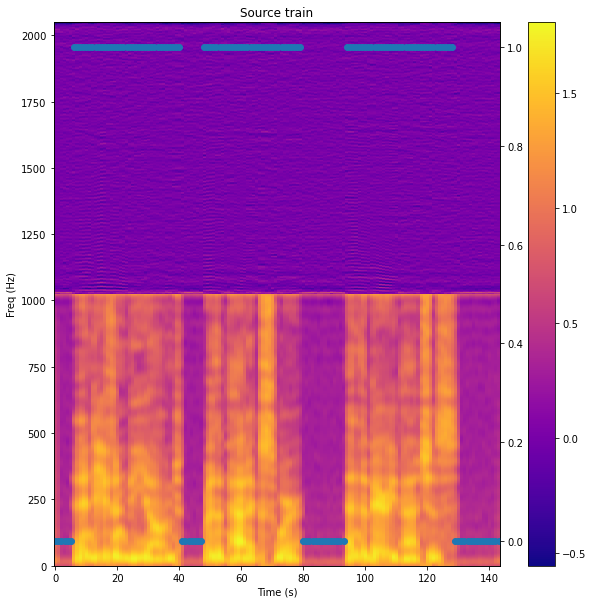

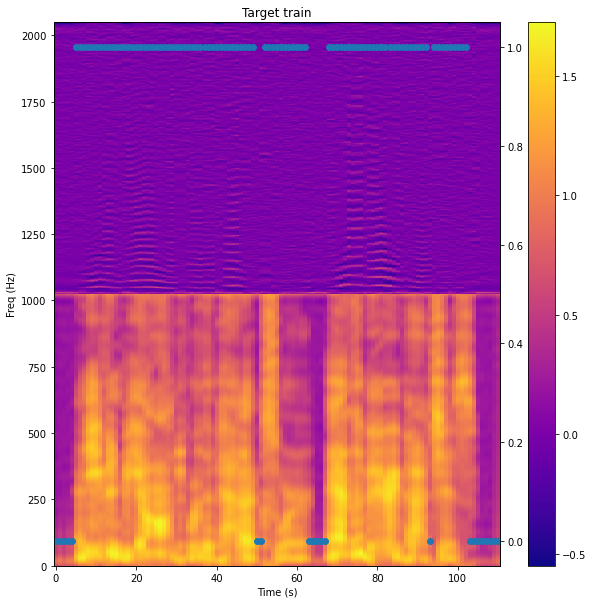

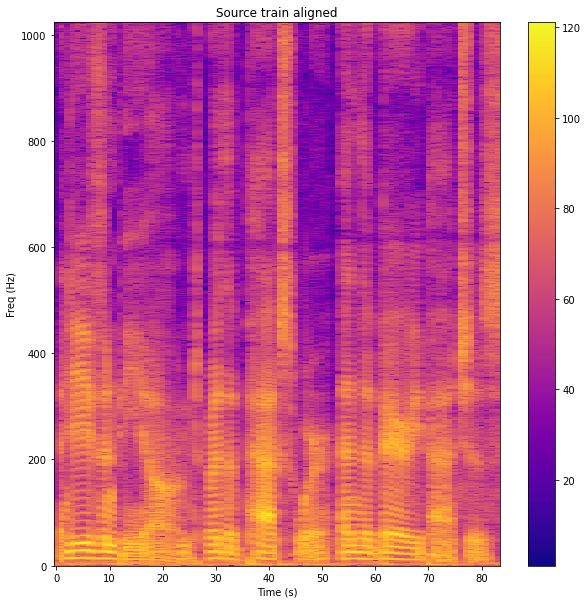

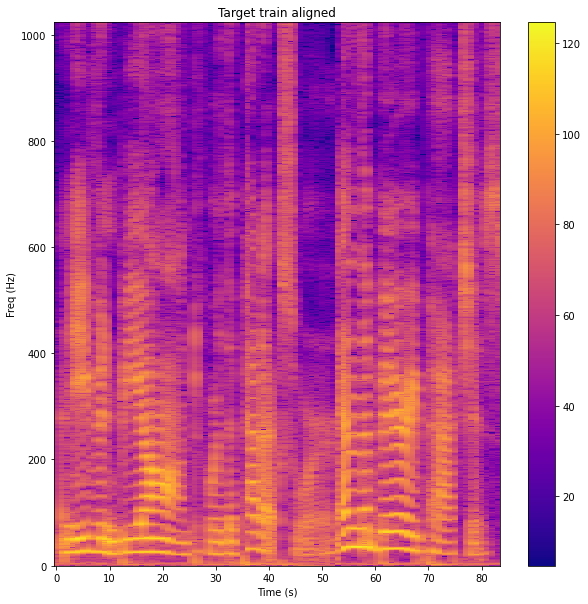

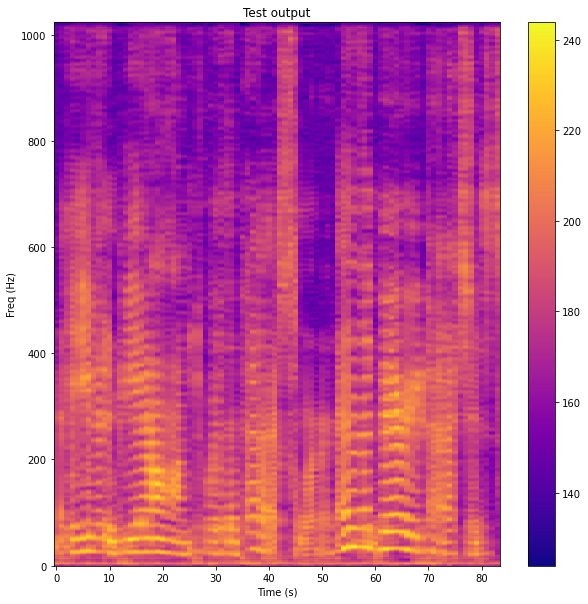

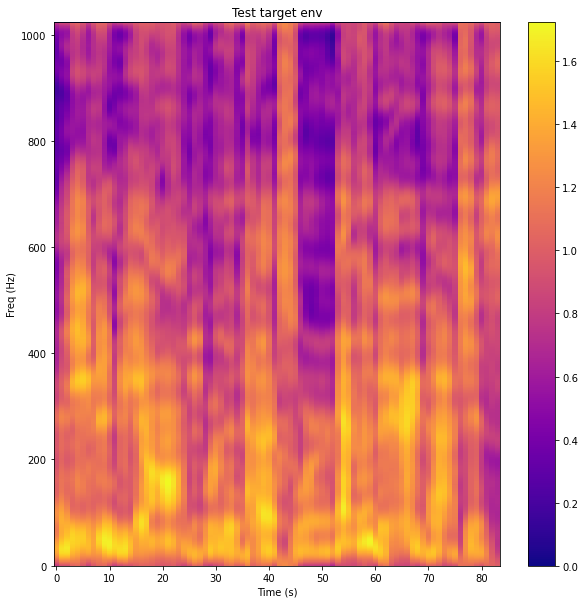

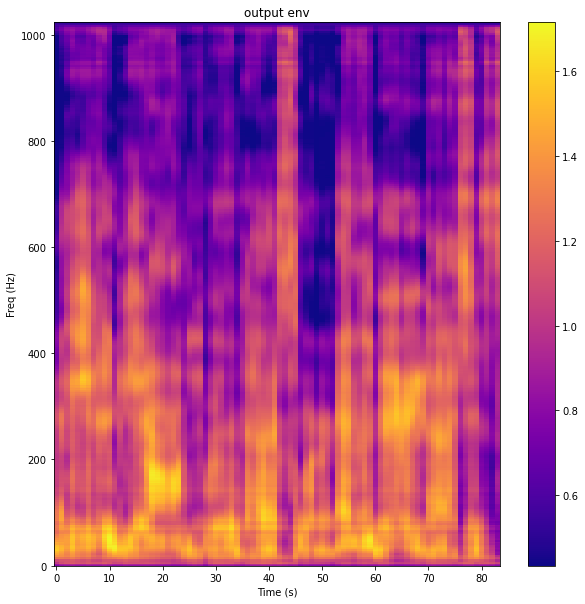

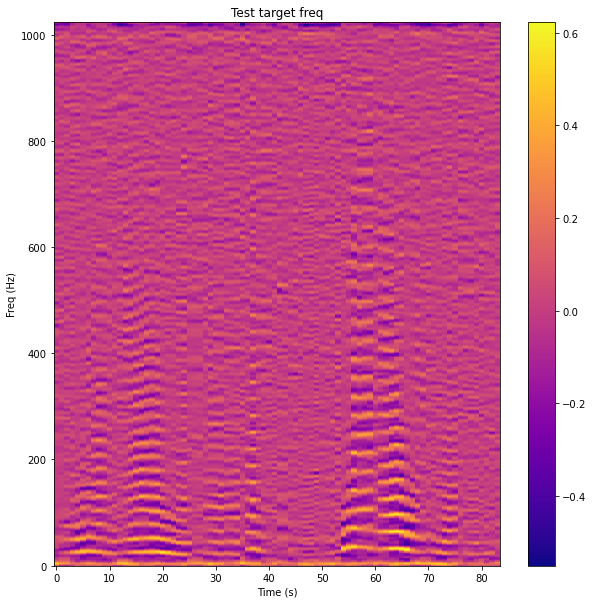

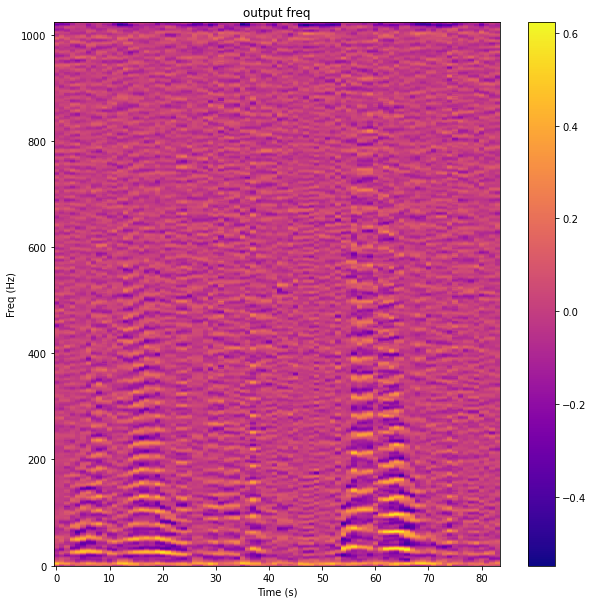

In [32]:
"""
This code block tests whether a model is "learnable" for a certain task
It simply fixes a single task and trains the model, and then it checks
model performance w.r.t. train set.
"""

def learnable_test(model, train_source_filename, train_target_filename,
                   vocode=True):
    from data.dataset import to_gen_model_output
    def plot_selected_frames(selected_frames):
        plt.twinx()
        plt.scatter(np.arange(selected_frames.size), selected_frames)

    task_dat = TaskDataset(train_source_filename, train_target_filename)
    # plot raw spec
    plot_spec(to_gen_model_output(task_dat.source.amp), title='Source train',
              figure_size=(10,10))
    plot_selected_frames(task_dat.source.selected_frames)
    plot_spec(to_gen_model_output(task_dat.target.amp), title='Target train',
              figure_size=(10,10))
    plot_selected_frames(task_dat.target.selected_frames)
    # plot aligned spec
    amp_x_aligned, amp_y_aligned = task_dat.get_as_aligned_amp()
    plot_spec(log_stft(amp_x_aligned), title='Source train aligned',
              figure_size=(10,10))
    plot_spec(log_stft(amp_y_aligned), title='Target train aligned',
          figure_size=(10,10))
    if vocode:
        sound(griffin_lim(amp_x_aligned), label='Source train aligned')
        sound(griffin_lim(amp_y_aligned), label='Target train aligned')
    # train
    train_x, train_y = task_dat.get()
    optimizer_mgr.create_instance(model)
    train(model,
          torch.from_numpy(train_x.astype(np.float32)),
          torch.from_numpy(train_y.astype(np.float32)),
          n_iter=5000, log_period=200, test_proportion=0.2) # TODO: tune this
    # test with train dataset
    estimated = model(torch.from_numpy(train_x).transpose(0, 1).to(device))
    raw_estimated = estimated.detach().cpu().numpy().T
    y = from_gen_model_output(estimated).detach().cpu().numpy().T
    # if isinstance(criterion, MelMSE):
    #     mel_y = criterion.mel(estimated.T).detach().cpu().numpy()
    #     mel_target = criterion.mel(
    #         torch.from_numpy(train_y.astype(np.float32)).to(device)
    #     ).detach().cpu().numpy()
    #     plot_spec(mel_y, title='mel y',figure_size=(10,10))
    #     plot_spec(mel_target, title='mel target',figure_size=(10,10))
    plot_spec(log_stft(y), title='Test output',figure_size=(10,10))
    plot_spec(train_y[:frame_size], title='Test target env',
              figure_size=(10,10))
    plot_spec(raw_estimated[:frame_size], title='output env',
              figure_size=(10,10))
    plot_spec(train_y[frame_size:], title='Test target freq',
              figure_size=(10,10))
    plot_spec(raw_estimated[frame_size:], title='output freq',
              figure_size=(10,10))
    if vocode:
        sound(griffin_lim(y), label='Test estimate')

learnable_test(model, meta_data.get(3, 0), meta_data.get(0, 0))


In [33]:
# Meta train

model = ModelClass().to(device)
optimizer_mgr.create_instance(model)

reptile_train(model, dataset, n_shot=None,
              n_iter_meta=1000, meta_step_size=5e-2,
              inner_train_func=train, n_iter_inner=10,
              log_period_meta=50, log_period_inner=2)

save_model('saved_models/' + type(model).__name__ + '.pt', model)

Meta iter 0 : 
Pass 0 :  0.37607017159461975
Pass 2 :  0.3728737235069275
Pass 4 :  0.3697880208492279
Pass 6 :  0.3667599856853485
Pass 8 :  0.36369842290878296
Meta iter 50 : 
Pass 0 :  0.29671087861061096
Pass 2 :  0.28990355134010315
Pass 4 :  0.28244417905807495
Pass 6 :  0.27523377537727356
Pass 8 :  0.26875537633895874
Meta iter 100 : 
Pass 0 :  0.24177400767803192
Pass 2 :  0.23621222376823425
Pass 4 :  0.23051565885543823
Pass 6 :  0.22534193098545074
Pass 8 :  0.22031797468662262
Meta iter 150 : 
Pass 0 :  0.19217035174369812
Pass 2 :  0.18768617510795593
Pass 4 :  0.18320545554161072
Pass 6 :  0.17897862195968628
Pass 8 :  0.17494738101959229
Meta iter 200 : 
Pass 0 :  0.15546157956123352
Pass 2 :  0.15088073909282684
Pass 4 :  0.1465824842453003
Pass 6 :  0.14298416674137115
Pass 8 :  0.13906517624855042
Meta iter 250 : 
Pass 0 :  0.11518115550279617
Pass 2 :  0.11050323396921158
Pass 4 :  0.10582815110683441
Pass 6 :  0.10183432698249817
Pass 8 :  0.09803371876478195
Meta 

In [34]:
print(type(model).__name__, ', number of params:', get_model_param_count(model))

CustomModel , number of params: 179279


In [35]:
# Second train after meta training

pretrained_model = load_model('saved_models/' + type(model).__name__ + '.pt',
                              ModelClass).to(device)


Pass 0 :  0.02511383593082428
Pass 100 :  0.015046891756355762
Pass 200 :  0.010790961794555187
Pass 300 :  0.007794087287038565
Pass 400 :  0.0065578268840909
Pass 500 :  0.005859187338501215
Pass 600 :  0.005453255493193865
Pass 700 :  0.005223751068115234
Pass 800 :  0.005252136383205652
Pass 900 :  0.004862111061811447
torch.Size([84, 2050])


torch.Size([84, 2050])
(1025, 84)


torch.Size([238, 2050])


torch.Size([231, 2050])
(1025, 231)


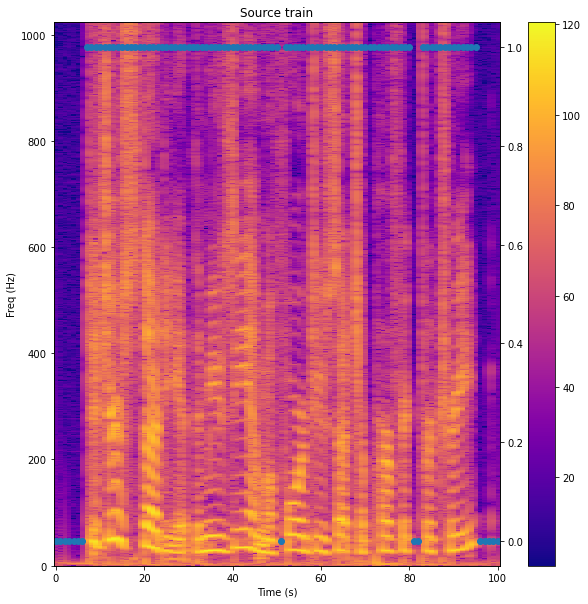

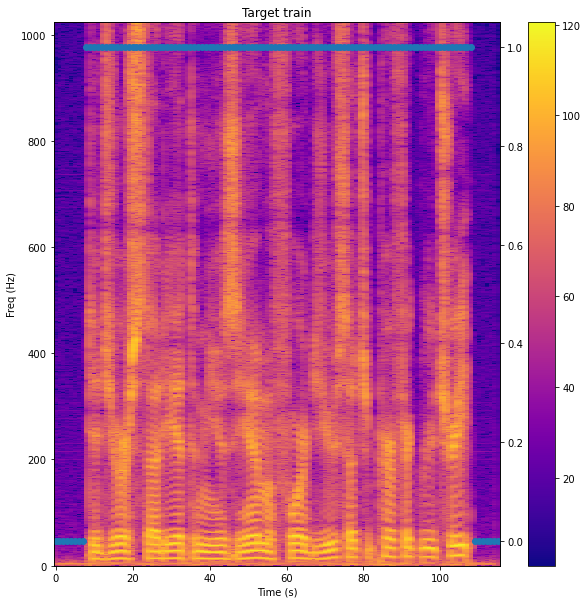

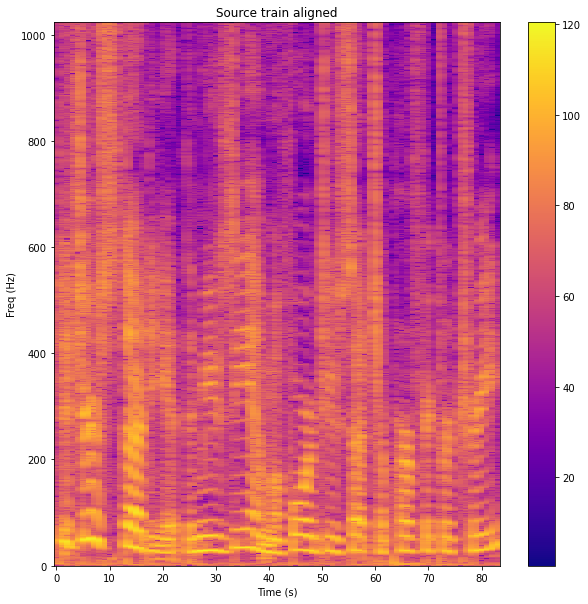

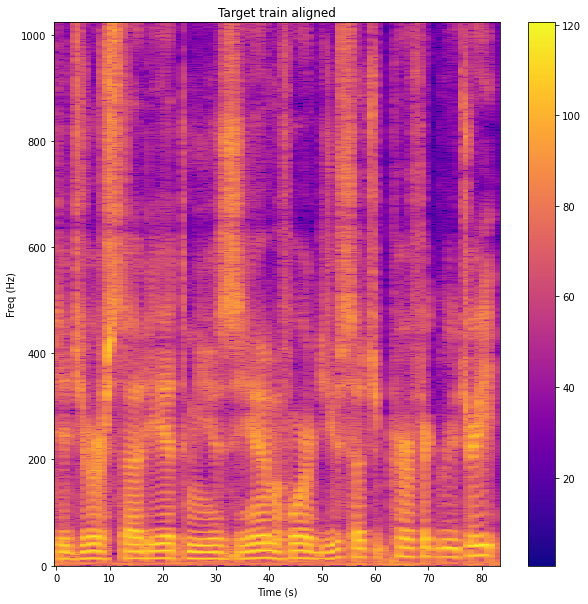

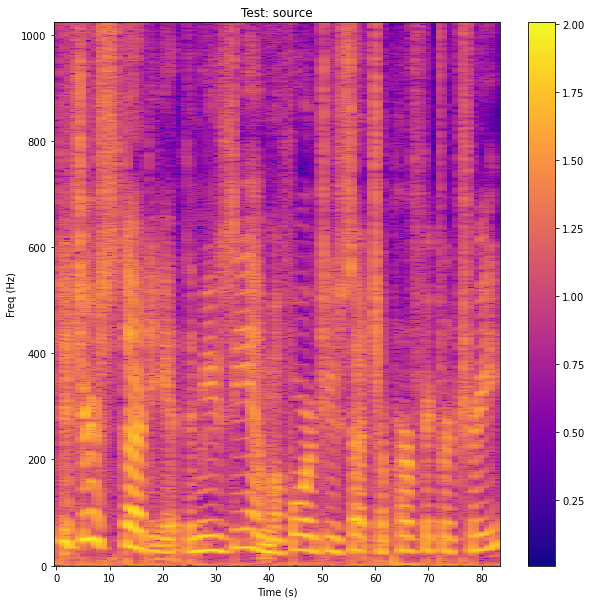

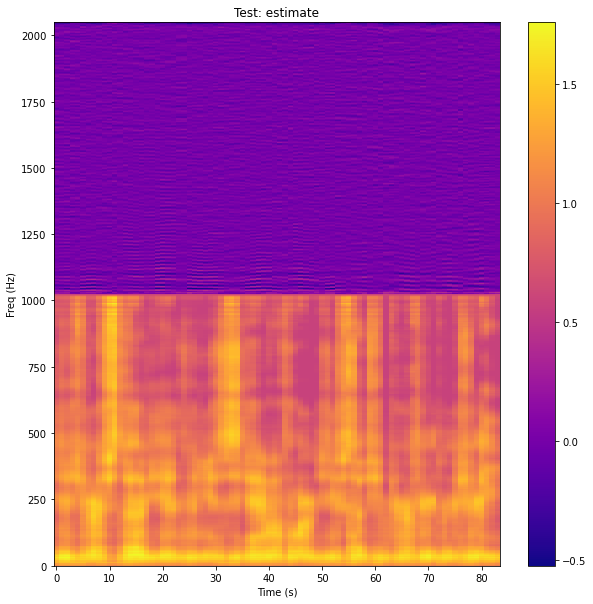

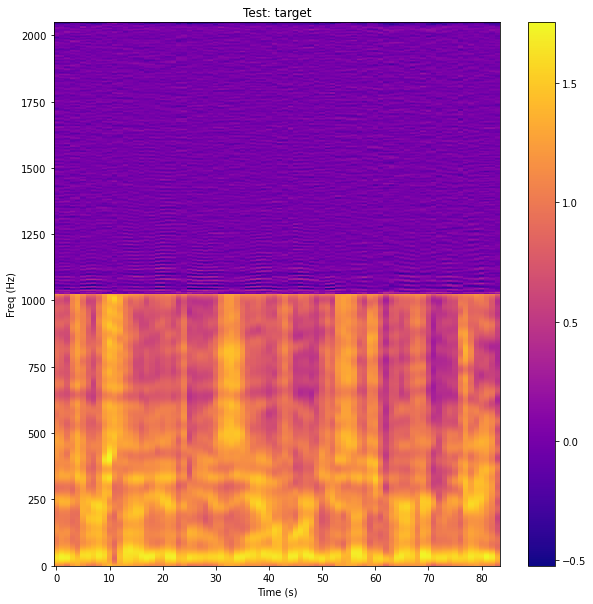

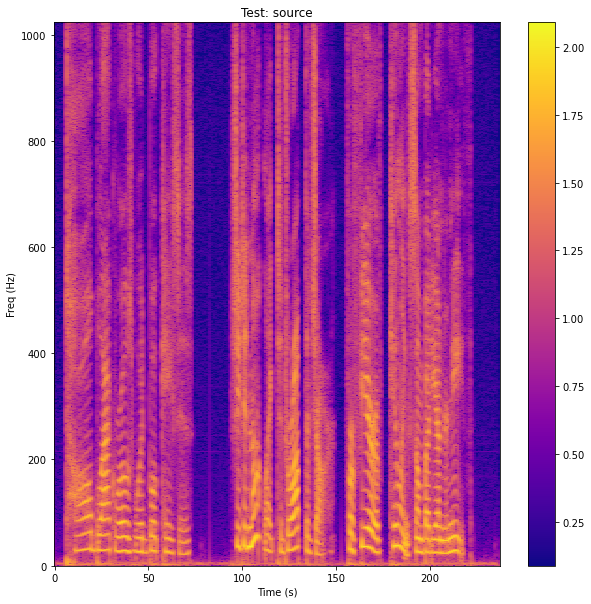

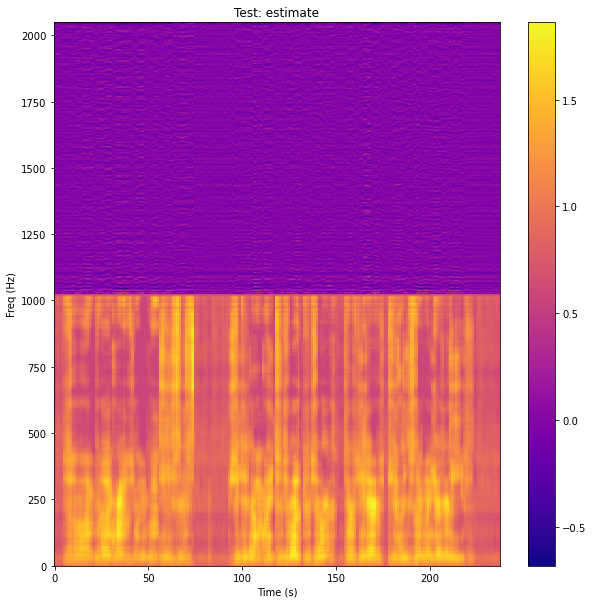

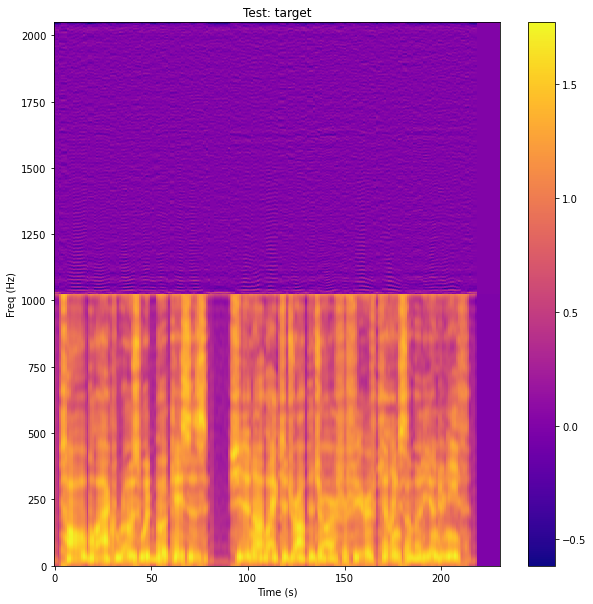

In [36]:
def test(model,
         train_source_filename, train_target_filename,
         test_input_filename, test_target_filename,
         second_train=False, vocode=True):
    def plot_selected_frames(selected_frames):
        plt.twinx()
        plt.scatter(np.arange(selected_frames.size), selected_frames)
    # raw audio
    task_dat = TaskDataset(train_source_filename, train_target_filename)
    input_dat = InputData(test_input_filename)
    plot_spec(log_stft(task_dat.source.amp), title='Source train',
              figure_size=(10,10))
    plot_selected_frames(task_dat.source.selected_frames)
    sound(read_audio(train_source_filename), label='Source train')
    plot_spec(log_stft(task_dat.target.amp), title='Target train',
              figure_size=(10,10))
    plot_selected_frames(task_dat.target.selected_frames)
    sound(read_audio(train_target_filename), label='Target train')
    # aligned audio
    amp_x_aligned, amp_y_aligned = task_dat.get_as_aligned_amp()
    plot_spec(log_stft(amp_x_aligned), title='Source train aligned',
              figure_size=(10,10))
    plot_spec(log_stft(amp_y_aligned), title='Target train aligned',
          figure_size=(10,10))
    if vocode:
        aligned_1 = griffin_lim(amp_x_aligned)
        aligned_2 = griffin_lim(amp_y_aligned)
        sound(aligned_1, label='Source train aligned')
        sound(aligned_2, label='Target train aligned')
        sound((aligned_1+aligned_2)/2, label='Combined aligned')

    if second_train:
        train_x, train_y = task_dat.get()
        optimizer_mgr.create_instance(model)
        train(model, torch.from_numpy(train_x), torch.from_numpy(train_y),
              n_iter=1000, log_period=100)

    def test_sample(x, target):
        from env import frame_size
        plot_spec(x[:frame_size], title='Test: source',
                  figure_size=(10,10))
        x = torch.from_numpy(x.T).to(device)
        estimated = model(x).detach().cpu()
        y = estimated.numpy().T
        # # pseudo
        # combined = (x.detach().cpu().numpy().T[:frame_size])
        # from utils import non_silent_frames
        # print(combined.shape, y.shape)
        # valid_indices= np.where(
        #     non_silent_frames(from_gen_model_output(combined)))[0]
        # print(len(valid_indices))
        # combined[:, valid_indices] = y[:, valid_indices]
        # y = combined
        #
        plot_spec(y, title='Test: estimate',figure_size=(10,10))

        if target is not None:
            plot_spec(target, title='Test: target',figure_size=(10,10))
        if vocode:
            sound(griffin_lim(from_gen_model_output(estimated).numpy().T),
                  label='Test: estimate')
            if target is not None:
                target = from_gen_model_output(target.T).numpy().T
                print(target.shape)
                sound(griffin_lim(target),
                      label='Test: target')
    if second_train:
        test_sample(train_x, torch.from_numpy(train_y))
    test_sample(input_dat.get(),
                torch.from_numpy(to_gen_model_output(
                    AudioData(test_target_filename).amp)))

source_speaker_id = 0
target_speaker_id = 3
train_audio_id = 3
test_audio_id = 5
test(pretrained_model,
     meta_data.get(source_speaker_id, train_audio_id),
     meta_data.get(target_speaker_id, train_audio_id),
     meta_data.get(source_speaker_id, test_audio_id),
     meta_data.get(target_speaker_id, test_audio_id),
     second_train=True, vocode=True)

In [37]:
# test with actual samples
